### Data Labling

In this notebook we are going to use [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) algorithim for clustering on the features that we are having so that we can give our dataset correct labels.

**What is clustering?**

> Grouping elements, things that belongs to the same category in the same group. Clustering involves finding groups
where all elements in the group are similar, but objects in different groups are not.

So after clustering our features all the features that belongs to the same category will be clustered to their own cluster. And later on we are going to use these clusters to create labels on our new dataset. We are intrested in labling our data using `3` labels which are loadsheding impacts on student performance. These labels are:

1. `None`
2. `Severe`
3. `Moderate`

> Note that the original dataset was having `4` classes. We are going to reduce this to `3`. These labels were:

1. `None`
2. `Severe`
3. `Moderate`
4. `Minimal`


In the following code cell we are going to import all the packages that we are going to use in this notebook.


In [1]:
import numpy as np
import pandas as pd
import os
import random
import time

from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

print("pandas:", pd.__version__)
print("numpy:", np.__version__)

pandas: 1.5.3
numpy: 1.24.3


We are then going to set the `SEED` for random operations that we are going to have for reproducivity.

In [2]:
SEED = 23
random.seed(SEED)
np.random.seed(SEED)

Next we are going to define the path to where our `loadshedding_effects_on_academic_performance.xlsx` file is located. This file contain the data of mislabeled features. And we are also going to define the `OUTPUT_PATH` wich is the path to the file with correct labeled dataset. We are going to save the correctly labeled dataset as a `csv` file with a name `loadshedding_effects_on_academic_performance.csv`

In [3]:
BASE_DIR = './'
DATA_PATH = os.path.join(BASE_DIR, 'data/', 'loadshedding_effects_on_academic_performance.xlsx')
OUTPUT_PATH = os.path.join(BASE_DIR, 'data/', 'loadshedding_effects_on_academic_performance.csv')

assert os.path.exists(DATA_PATH), f"The path '{DATA_PATH}' does not exists."

Next we are going to read our `loadshedding_effects_on_academic_performance.xlsx` file into a dataframe and check the last `5` rows that are in this dataset.

In [4]:
dataframe = pd.read_excel(DATA_PATH)
dataframe.tail().reset_index(drop=True)

,Student ID,Institution,Year of Study,GPA,Loadshedding Frequency,Loadshedding Duration,Loadshedding Impact
0,15224,University of Cape Town,2,2.261930,0,20.553965,Severe
1,78007,Stellenbosch University,4,1.789417,4,8.499748,None
2,30101,University of Johannesburg,4,3.235504,1,15.075249,Minimal
3,84843,University of KwaZulu-Natal,3,3.691792,2,4.200950,Moderate
4,19206,University of Pretoria,4,2.787871,3,18.108455,Severe


Next we are going to store `Student ID` in a numpy array before we drop those student numbers because in our output dataset we will need these student numbers back.

In [5]:
ids = dataframe['Student ID']
dataframe.drop(columns=['Student ID'], inplace=True)
dataframe.head()

,Institution,Year of Study,GPA,Loadshedding Frequency,Loadshedding Duration,Loadshedding Impact
0,University of Cape Town,4,2.137368,6,6.304662,None
1,Stellenbosch University,2,3.911333,5,0.489955,Minimal
2,University of Johannesburg,4,3.092123,1,2.462164,Moderate
3,University of KwaZulu-Natal,1,0.000000,4,7.756866,Severe
4,University of Pretoria,1,2.136559,3,0.085806,None


We can check our unique labels using that we are having in the following code cell.

In [6]:
labels = dataframe['Loadshedding Impact'].unique()
labels

array(['None', 'Minimal', 'Moderate', 'Severe'], dtype=object)

From our clustering task we are going to learn few features which are:

1. `Loadshedding Frequency`
2. `GPA`
3. `Loadshedding Duration`

These are the features that we think that they have a greater impact on student performance on loadshedding. So other columns will be dropped.


We are ignoring the `Year of Study` column because we are assuming that all students that are taking this survey are in the same grade.

In [7]:
features_df = dataframe.drop(["Loadshedding Impact", 'Institution', 'Year of Study'], axis=1)
features_df.head()

,GPA,Loadshedding Frequency,Loadshedding Duration
0,2.137368,6,6.304662
1,3.911333,5,0.489955
2,3.092123,1,2.462164
3,0.000000,4,7.756866
4,2.136559,3,0.085806


So we are going to create a pipeline that will work on tranforming our data in the way that we want. We are going to use something called [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) from `sklearn`. We are going to encode each column surperately. Here are the transformations that we are going to make for our featues.

1. GPA	-[`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
2. Loadshedding Frequency - [`MinMaxScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)	
3. Loadshedding Duration [`MinMaxScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)	

In [8]:
ct = ColumnTransformer(
    [
        ('standard_scaler',StandardScaler(), ['GPA']),
        ("min_max_scaler", MinMaxScaler(), ["Loadshedding Frequency", "Loadshedding Duration"]),
    ]
)
features_transformed = ct.fit_transform(features_df)

We can check the first 2 `rows` of the transformed features in the following code cell as follows:

In [9]:
features_transformed[:2]

array([[0.40415235, 1.        , 0.2626795 ],
       [1.94113777, 0.83333333, 0.02038944]])

Next we are going to create a clusting model using the [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) algorithm. We are setting the `n_clusters` to `3` because we want to cluster our features into `3` classes which are:

1. `None`
2. `Severe`
3. `Moderate`



In [10]:
N_CLUSTERS = 3
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=SEED, n_init=10)
kmeans.fit(features_transformed)

KMeans(n_clusters=3, n_init=10, random_state=23)

We can check the labels that we got from the algorithm using the `labels_` propety as follows:

In [11]:
kmeans.labels_

array([2, 0, 0, ..., 0, 0, 0])

We can check the unique labels using the `set()` method as follows:

In [12]:
set(kmeans.labels_)

{0, 1, 2}

We can check the `score` of our algorithm using the `score` method and pass the features as follows:

In [13]:
kmeans.score(features_transformed)

-6016.348272914765

Now it's time to analyse our predictions dataframe rows before relabling them using the clustering algorithm. First we are going to check the our dataframe head by calling the `head` method. But we are going to attech some `prediction` column on this dataframe so that we can analyse how the model is labling our dataset together with our eyes we are going to map `{0, 1, 2}` to our target labels `{None, Severe, Moderate}`

In [22]:
dataframe['prediction'] = kmeans.predict(features_transformed)
dataframe.head(20)

,Institution,Year of Study,GPA,Loadshedding Frequency,Loadshedding Duration,Loadshedding Impact,Student ID,prediction
0,University of Cape Town,4,2.137368,6,6.304662,None,55433,2
1,Stellenbosch University,2,3.911333,5,0.489955,Moderate,28988,0
2,University of Johannesburg,4,3.092123,1,2.462164,Moderate,81080,0
3,University of KwaZulu-Natal,1,0.000000,4,7.756866,Severe,79415,1
4,University of Pretoria,1,2.136559,3,0.085806,None,91607,2
5,University of Cape Town,4,1.558813,5,6.659326,None,59629,2
6,Stellenbosch University,2,2.829724,1,20.138214,Moderate,22988,0
7,University of Johannesburg,1,0.321083,2,4.352817,Severe,23303,1
8,University of KwaZulu-Natal,4,2.525481,6,15.603284,Moderate,13328,0
9,University of Pretoria,3,3.948151,0,7.722580,Moderate,84218,0


Next we are going to create a `labels_dict` which maps a number to a categorical label as follows:

In [23]:
labels_dict = {
    1: 'Severe',
    0: 'Moderate',
    2: 'None'
}

> Note that the we used our eyes together with the use of the `clustering` model to come up with the categorical labels. Next we are going to label our dataset by updating the `Loadshedding Impact` column, add the `Student ID` column and droping the `prediction` label as follows:

In [24]:
def set_label(row):
    l = row.prediction
    row['Loadshedding Impact'] = labels_dict[l]
    return row

dataframe = dataframe.apply(set_label, axis=1)
dataframe['Student ID'] = ids
dataframe.drop(columns=['prediction'], inplace=True)

We can check the first `20` rows of the labeled dataset using the `head()` method as follows:

In [25]:
dataframe.head(20)

,Institution,Year of Study,GPA,Loadshedding Frequency,Loadshedding Duration,Loadshedding Impact,Student ID
0,University of Cape Town,4,2.137368,6,6.304662,None,55433
1,Stellenbosch University,2,3.911333,5,0.489955,Moderate,28988
2,University of Johannesburg,4,3.092123,1,2.462164,Moderate,81080
3,University of KwaZulu-Natal,1,0.000000,4,7.756866,Severe,79415
4,University of Pretoria,1,2.136559,3,0.085806,None,91607
5,University of Cape Town,4,1.558813,5,6.659326,None,59629
6,Stellenbosch University,2,2.829724,1,20.138214,Moderate,22988
7,University of Johannesburg,1,0.321083,2,4.352817,Severe,23303
8,University of KwaZulu-Natal,4,2.525481,6,15.603284,Moderate,13328
9,University of Pretoria,3,3.948151,0,7.722580,Moderate,84218


Now that we have relabeled our dataset next we are going to save our dataset as a `csv` file as follows:

In [26]:
dataframe.to_csv(OUTPUT_PATH, index=False)
print('Saved!!')

Saved!!


We can visualize the first `100` examples to their respective clusters or `classes` as follows:

In [31]:
n = 150
y = [i.mean() for i in features_transformed[:n]]
x = np.arange(n)
c = kmeans.labels_[:n]

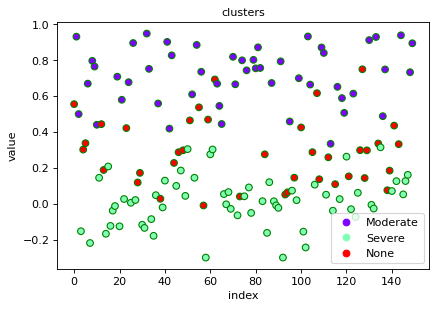

In [32]:
plt.figure(figsize=(6, 4), dpi=80)
scatter = plt.scatter(x, y, c=c, cmap='rainbow', edgecolor="g")
plt.title("clusters", color="k", fontsize=10)
plt.xlabel("index", fontsize=10)
plt.ylabel("value", fontsize=10)
plt.legend(handles=scatter.legend_elements()[0], labels=[labels_dict[i] for i in set(kmeans.labels_)])
plt.show()

### Refs

1. [scikit-learn.org](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
2. [github.com/CrispenGari](https://github.com/CrispenGari/python-sklearn/blob/main/unsupervised_learning/unsupervised_learning.ipynb)